In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
import numpy as np

2025-01-23 18:09:08.006172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 18:09:08.015323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737652148.026224  284224 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737652148.029567  284224 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:09:08.040699: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
loaded_encoder = np.load('encoder.npz')
one_hot_encoder = {key: loaded_encoder[key] for key in loaded_encoder}

In [3]:
VOCAB_SIZE: int = 91
SEQ_SIZE: int = 150

In [4]:
def split_encode(text: str) -> list[list[int]]:
    global one_hot_encoder
    global SEQ_SIZE
    encoded = [one_hot_encoder[x] for x in [*text][:SEQ_SIZE]]
    padded = encoded + [one_hot_encoder["<pad>"]] * (SEQ_SIZE - len(encoded))
    return padded

In [5]:
titles = np.load("dataset/text_shrink.npy")

In [6]:
data = np.array([split_encode(text) for text in titles])

In [7]:
BATCH_SIZE = 8

In [8]:
X = data[:, :-1, :] 
y = data[:, 1:, :] 

In [9]:
del data

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

W0000 00:00:1737652209.966357  284224 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQ_SIZE - 1, VOCAB_SIZE)),
    tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [13]:
history = model.fit(dataset, epochs=15)

Epoch 1/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 173s 46ms/step - loss: 2.1950
Epoch 2/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 163s 43ms/step - loss: 1.6574
Epoch 3/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 164s 44ms/step - loss: 1.5416
Epoch 4/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 182s 48ms/step - loss: 1.4750
Epoch 5/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 171s 46ms/step - loss: 1.4239
Epoch 6/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 154s 41ms/step - loss: 1.3928
Epoch 7/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 162s 43ms/step - loss: 1.3734
Epoch 8/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 182s 49ms/step - loss: 1.3546
Epoch 9/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 187s 50ms/step - loss: 1.3373
Epoch 10/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 189s 51ms/step - loss: 1.3266
Epoch 11/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 176s 47ms/step - loss: 1.3165
Epoch 12/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 175s 47ms/step - loss: 1.3090
Epoch 13/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 186s 50ms/step - loss: 1.3013
Epoch 14/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 188s 50ms/step - 

In [14]:
def encode(src: str) -> np.ndarray:
    dst = []
    for letter in [*src]:
        dst.append(one_hot_encoder[letter])
    return np.array(dst)

In [15]:
def decode(src: np.ndarray) -> str:
    dst = ""
    for coded in src:
        for key, val in one_hot_encoder.items():
            if (coded == val).all():
                dst += key
                break
    return dst

In [16]:
input_seq = encode("Breaking news: ")

In [17]:
def generate_sequence(model, start_sequence, seq_length, decode):
    current_input = np.copy(start_sequence)  
    generated_sequence = decode(current_input)  
    for _ in range(seq_length):
        predictions = model.predict(current_input[np.newaxis, ...], verbose=0) 
        
        next_char_idx = np.argmax(predictions[0, -1, :])
        
        next_char_onehot = np.zeros_like(current_input[0])
        next_char_onehot[next_char_idx] = 1

        current_input = np.roll(current_input, shift=-1, axis=0)
        current_input[-1] = next_char_onehot  
        
        generated_sequence += decode(next_char_onehot[np.newaxis, ...])
    
    return generated_sequence

In [18]:
generated_text = generate_sequence(model, input_seq, SEQ_SIZE, decode)
print(generated_text)

Breaking news: The Obama administration s all of the political companies to the presidential campaign to the presidential campaign to the presidential campaign to th


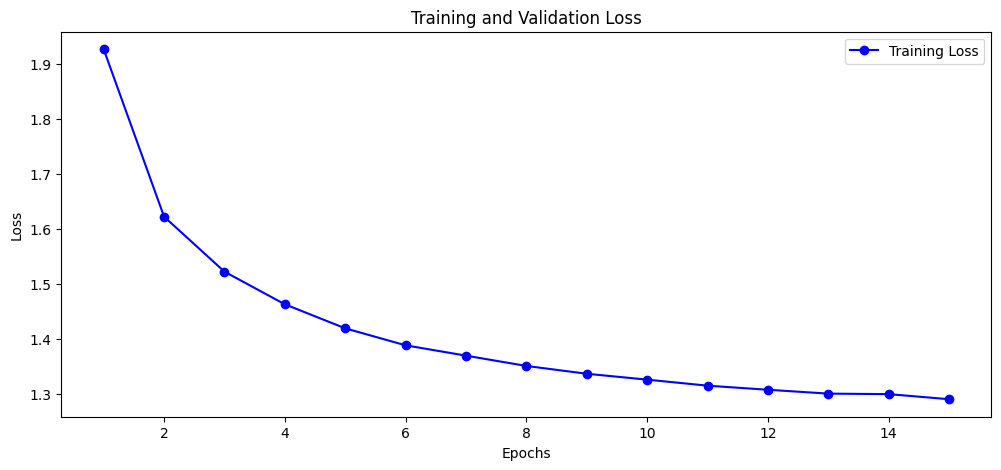

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']  
epochs = range(1, len(loss) + 1)  

val_loss = history_dict.get('val_loss', None)
accuracy = history_dict.get('accuracy', None)
val_accuracy = history_dict.get('val_accuracy', None)

plt.figure(figsize=(12, 5))

plt.plot(epochs, loss, 'bo-', label='Training Loss') 
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [20]:
model.save("generator_dropout_complex_shrink_seq.keras")